In [ ]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
reviews = pd.read_csv('/home/ab/Downloads/Datasets for analysis/Amazon reviews/amazon_alexa.tsv', sep = '\t', quotechar = '"')
reviews.info()
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         

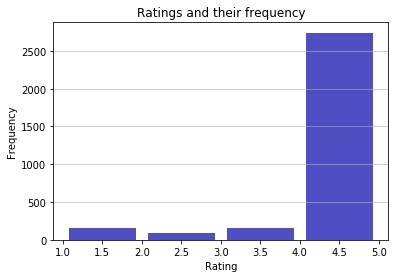

In [5]:
#Let's look at the distribution of reviews
n, bins, patches = plt.hist(x=reviews.rating, bins=[1,2,3,4,5], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings and their frequency')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()

In [8]:
reviews["review_len"] = np.nan
reviews.head()
for i in range(len(reviews.verified_reviews)):
    reviews.review_len[i] = len(reviews.verified_reviews[i])

/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
#Test out that it's working
print(reviews.review_len[0:10])
isinstance(reviews.review_len, int)
#reviews.review_len = int(reviews.review_len)
reviews.info()

0     13.0
1      9.0
2    195.0
3    172.0
4      5.0
5    172.0
6    365.0
7    221.0
8     11.0
9    114.0
Name: review_len, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 6 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
review_len          3150 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 147.7+ KB


In [8]:
reviews.columns = reviews.columns.to_series().apply(lambda x: x.strip())

In [6]:
polar_reviews = reviews.query("rating < 3 or rating > 3")
polar_reviews.info()
print(polar_reviews.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 0 to 3149
Data columns (total 5 columns):
rating              2998 non-null int64
date                2998 non-null object
variation           2998 non-null object
verified_reviews    2998 non-null object
feedback            2998 non-null int64
dtypes: int64(2), object(3)
memory usage: 140.5+ KB
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         

In [7]:
polar_reviews['polarity'] = np.random.randn(len(polar_reviews.verified_reviews))
print(polar_reviews.head())
polar_reviews['polarity'].loc[(polar_reviews['rating'] == 5) | (polar_reviews['rating'] == 4)] = 1
polar_reviews['polarity'].loc[(polar_reviews['rating'] == 2) | (polar_reviews['rating'] == 1)] = 0
print(polar_reviews.head())

/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ab/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  polarity  
0                                      Love my Echo!         1 -1.718050  
1                                          Loved it!         1 -0.353984  
2  Sometimes while playing a game, you can answer...         1 -0.860477  
3  I have had a lot of fun with this thing. My 4 ...         1  1.184971  
4                                              Music         1 -0.707078  
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified

/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
x = polar_reviews['verified_reviews']
y = polar_reviews['polarity']

def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

sample_text = "Hey there! Six Seasons and a movie! Pierce sucks!"
print(text_process(sample_text))


['Hey', 'Six', 'Seasons', 'movie', 'Pierce', 'sucks']


In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(x)
#from sklearn.feature_extraction.text import TfidfVectorizer

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
#vectorizer = TfidfVectorizer(ngram_range=(1,2))
#t1 = datetime.now()

# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
#X = vectorizer.fit_transform(x)
#print(datetime.now() - t1)

In [13]:
len(bow_transformer.vocabulary_)
review_255 = x[255]
print(review_255)
bow_25 = bow_transformer.transform([review_255])
print(bow_25)

We are loving Ours very much
  (0, 3087)	1
  (0, 3231)	1


In [14]:
print(bow_transformer.get_feature_names()[1143])
X = bow_transformer.transform(x)
#print(vectorizer.get_feature_names()[1143])
#X = vectorizer.fit_transform(x)

ability


In [15]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))

Shape of Sparse Matrix:  (2998, 4941)
Amount of Non-Zero occurrences:  34931


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

In [17]:
#from sklearn.naive_bayes import MultinomialNB

#nb = MultinomialNB()
#nb.fit(X_train, y_train)
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
preds = clf.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 34  36]
 [ 17 813]]


             precision    recall  f1-score   support

        0.0       0.67      0.49      0.56        70
        1.0       0.96      0.98      0.97       830

avg / total       0.93      0.94      0.94       900



In [50]:
#So we are actually able to get this right most of the time. Let's try with predicting the actual ratings.
x_rating = reviews['verified_reviews']
y_rating = reviews['rating']
bow_transformer = CountVectorizer(analyzer=text_process).fit(x_rating)
#vectorizer = TfidfVectorizer(ngram_range=(1,2))
#X = vectorizer.fit_transform(x_rating)
len(bow_transformer.vocabulary_)
review_25 = x_rating[25]
bow_25 = bow_transformer.transform([review_25])
bow_25
print(bow_transformer.get_feature_names()[1143])
X = bow_transformer.transform(x_rating)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Shape of y:', np.shape(y_rating))

Waste
Shape of Sparse Matrix:  (3150, 5211)
Amount of Non-Zero occurrences:  37628
Shape of y: (3150,)


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_rating, test_size=0.3, random_state=2017)

In [31]:
from sklearn import svm

#Create a svm Classifier
clf_rating = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_rating.fit(X_train, y_train)

#from sklearn.naive_bayes import MultinomialNB

#nb_rating = MultinomialNB()
#nb_rating.fit(X_train, y_train)

predictions = clf_rating.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

0.7481481481481481
             precision    recall  f1-score   support

          1       0.54      0.42      0.47        48
          2       0.33      0.29      0.31        28
          3       0.42      0.36      0.38        42
          4       0.41      0.28      0.33       138
          5       0.83      0.91      0.87       689

avg / total       0.72      0.75      0.73       945



In [22]:
#Okay, perhaps the model needs more data
food_reviews = pd.read_csv('/home/ab/Downloads/amazon-fine-food-reviews/stratified_reviews.csv', sep = ',', quotechar = '"')
food_reviews.info()
print(food_reviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
Unnamed: 0                25000 non-null int64
Id                        25000 non-null int64
ProductId                 25000 non-null object
UserId                    25000 non-null object
ProfileName               24997 non-null object
HelpfulnessNumerator      25000 non-null int64
HelpfulnessDenominator    25000 non-null int64
Score                     25000 non-null int64
Time                      25000 non-null int64
Summary                   24996 non-null object
Text                      25000 non-null object
dtypes: int64(6), object(5)
memory usage: 2.1+ MB
   Unnamed: 0      Id   ProductId          UserId     ProfileName  \
0           1  526171  B006ABD3DY  A19THLC5ICNIKV         artlady   
1           2  308012  B001BS4G6O   AOA0GQX1RWKT1      Janet Chou   
2           3  269420  B000P41A46  A3Q2SN758CPI16  Cornelia Stutz   
3           4  166115  B001CWV4RS  A2J1MM9A

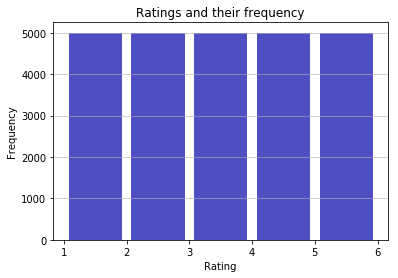

In [23]:
n, bins, patches = plt.hist(x=food_reviews.Score, bins=[1,2,3,4,5,6], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings and their frequency')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()

In [24]:
x_food = food_reviews['Text']
y_food = food_reviews['Score']

In [59]:
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

sample_text = "Hey there! Six Seasons and a movie! Pierce sucks!"
print(text_process(sample_text))

['Hey', 'Six', 'Seasons', 'movie', 'Pierce', 'sucks']


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
food_vec = vectorizer.fit_transform(x_food)

In [60]:
#If you have run the previous cell, don't run this one
bow_transformer = CountVectorizer(analyzer=text_process).fit(x_food)
len(bow_transformer.vocabulary_)
review_25 = x_food[25]
bow_25 = bow_transformer.transform([review_25])
bow_25
print(bow_transformer.get_feature_names()[1143])
food_vec = bow_transformer.transform(x_food)

24pack


In [61]:
print('Shape of Sparse Matrix: ', food_vec.shape)
print('Amount of Non-Zero occurrences: ', food_vec.nnz)
# Percentage of non-zero values
density = (100.0 * food_vec.nnz / (food_vec.shape[0] * food_vec.shape[1]))
print('Shape of y:', np.shape(y_food))

Shape of Sparse Matrix:  (25000, 54948)
Amount of Non-Zero occurrences:  948204
Shape of y: (25000,)


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(food_vec, y_food, test_size=0.25, random_state=2017)

In [64]:
#from sklearn.naive_bayes import MultinomialNB
#nb_food = MultinomialNB()
#nb_food.fit(X_train, y_train)
#predictions = nb_food.predict(X_test)

from sklearn import svm

#Create a svm Classifier
clf_food = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_food.fit(X_train, y_train)

predictions = clf_food.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))
#Naive Bayes with TF-IDF: 54%[61,50,48,50,59]
#Naive Bayes with BOW: 47%[55,43,49,43,54]
#SVM with TF-IDF: 55%[65,49,49,48,65]
#SVM with BOW: 48%[58,44,41,43,53]

[[779 280 120  49  43]
 [301 577 220 100  46]
 [165 278 512 199  93]
 [ 84 145 259 517 258]
 [ 85  91 143 298 608]]


             precision    recall  f1-score   support

          1       0.55      0.61      0.58      1271
          2       0.42      0.46      0.44      1244
          3       0.41      0.41      0.41      1247
          4       0.44      0.41      0.43      1263
          5       0.58      0.50      0.53      1225

avg / total       0.48      0.48      0.48      6250



In [30]:
polar_food = food_reviews.query("Score < 3 or Score > 3")
polar_food.info()
print(polar_food.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 11 columns):
Unnamed: 0                20000 non-null int64
Id                        20000 non-null int64
ProductId                 20000 non-null object
UserId                    20000 non-null object
ProfileName               19997 non-null object
HelpfulnessNumerator      20000 non-null int64
HelpfulnessDenominator    20000 non-null int64
Score                     20000 non-null int64
Time                      20000 non-null int64
Summary                   19997 non-null object
Text                      20000 non-null object
dtypes: int64(6), object(5)
memory usage: 1.8+ MB
   Unnamed: 0      Id   ProductId          UserId     ProfileName  \
0           1  526171  B006ABD3DY  A19THLC5ICNIKV         artlady   
1           2  308012  B001BS4G6O   AOA0GQX1RWKT1      Janet Chou   
2           3  269420  B000P41A46  A3Q2SN758CPI16  Cornelia Stutz   
3           4  166115  B001CWV4RS  A2J1MM9A

In [32]:
polar_food['polarity'] = np.random.randn(len(polar_food.Text))
print(polar_food.head())
polar_food['polarity'].loc[(polar_food['Score'] == 5) | (polar_food['Score'] == 4)] = 1
polar_food['polarity'].loc[(polar_food['Score'] == 2) | (polar_food['Score'] == 1)] = 0
print(polar_food.head())

/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ab/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

   Unnamed: 0      Id   ProductId          UserId     ProfileName  \
0           1  526171  B006ABD3DY  A19THLC5ICNIKV         artlady   
1           2  308012  B001BS4G6O   AOA0GQX1RWKT1      Janet Chou   
2           3  269420  B000P41A46  A3Q2SN758CPI16  Cornelia Stutz   
3           4  166115  B001CWV4RS  A2J1MM9A9F9LX9          Lisa S   
4           5  439179  B004IJHY4Y  A2KZVGG2PS3WB3        Tsclower   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     4                       4      5  1331596800   
1                     1                       1      5  1230422400   
2                     0                       0      5  1347926400   
3                     0                       0      5  1209600000   
4                     4                       4      5  1287360000   

                                             Summary  \
0                                  salt of the earth   
1  It takes away the aggravation in feeding your ...

/home/ab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
x_food_p = polar_food['Text']
y_food_p = polar_food['polarity']

In [41]:
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

sample_text = "Hey there! Six Seasons and a movie! Pierce sucks!"
print(text_process(sample_text))


['Hey', 'Six', 'Seasons', 'movie', 'Pierce', 'sucks']


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
food_vec_p = vectorizer.fit_transform(x_food_p)

In [42]:
#If you have run the previous cell, don't run this one
bow_transformer_p = CountVectorizer(analyzer=text_process).fit(x_food_p)
len(bow_transformer_p.vocabulary_)
review_25 = x_food_p[25]
bow_25 = bow_transformer_p.transform([review_25])
bow_25
print(bow_transformer_p.get_feature_names()[1143])
food_vec_p = bow_transformer_p.transform(x_food_p)

2pm


In [48]:
print('Shape of Sparse Matrix: ', food_vec_p.shape)
print('Amount of Non-Zero occurrences: ', food_vec_p.nnz)
# Percentage of non-zero values
density = (100.0 * food_vec_p.nnz / (food_vec_p.shape[0] * food_vec_p.shape[1]))
print('Shape of y:', np.shape(y_food_p))

Shape of Sparse Matrix:  (20000, 432678)
Amount of Non-Zero occurrences:  2662985
Shape of y: (20000,)


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(food_vec_p, y_food_p, test_size=0.33, random_state=2017)

In [51]:
from sklearn.naive_bayes import MultinomialNB
nb_food_p = MultinomialNB()
nb_food_p.fit(X_train, y_train)
predictions = nb_food_p.predict(X_test)

#from sklearn import svm

#Create a svm Classifier
#clf_food_p = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
#clf_food_p.fit(X_train, y_train)

#predictions = clf_food_p.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

#Naive Bayes with BOW: F1 score of 82%
#SVM with BOW: 83%
#SVM with TF-IDF: 89%
#Naive Bayes with TF-IDF: 88%

[[2947  383]
 [ 419 2851]]


             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88      3330
        1.0       0.88      0.87      0.88      3270

avg / total       0.88      0.88      0.88      6600

